<a href="https://colab.research.google.com/github/ed-chin-git/DS-Unit-4-Sprint-1-Tree-Ensembles/blob/master/DS41SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

### load and inspect data:

In [1]:
!pip install category_encoders

In [2]:
!pip install pdpbox

In [3]:
!pip install eli5

    100% |████████████████████████████████| 102kB 4.6MB/s 


In [0]:
import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

X_train = pd.read_csv(train_url)

X_test  = pd.read_csv(test_url)

assert X_train.shape == (51916, 17)
assert X_test.shape  == (17306, 17)

In [6]:
columns=X_train.columns.tolist()
columns

['Inspection ID',
 'DBA Name',
 'AKA Name',
 'License #',
 'Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Inspection Type',
 'Violations',
 'Latitude',
 'Longitude',
 'Location',
 'Fail']

In [7]:
X_train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._


In [0]:
X_train_saved=X_train.copy()
X_test_saved=X_test.copy()


In [9]:
X_train=X_train_saved.copy()
X_test=X_test_saved.copy()
def wrangle(X):
    X1 = X.copy()
    #  Drop some useless features
    X = X.drop(columns='Inspection ID')
    X = X.drop(columns='License #')
    X = X.drop(columns='Zip')
    X = X.drop(columns='DBA Name') 
    X = X.drop(columns='AKA Name') # Duplicative of 'DBA Name'

    #  maybe useless??
    X = X.drop(columns='Address')
    X = X.drop(columns='City')
    X = X.drop(columns='State')
    X = X.drop(columns='Latitude')
    X = X.drop(columns='Longitude')
    X = X.drop(columns='Location')
    #  bitwise NOT is the ~    this sets any null to FALSE (no violation)
    #                                  and non-nulls to TRUE (violation)
    X['Violations'] = ~X['Violations'].isnull()
    
    #  Feature Engineer --->  calculate days since last inspection
    X['Inspection Date'] = pd.to_datetime(X['Inspection Date'], infer_datetime_format=True) # `infer_datetime_format=True` makes it go faster
    X['Days Since']  = pd.Timestamp.today() - X['Inspection Date']  # (difference from today )
    X['Days Since'] = X['Days Since'].dt.days
    X = X.drop(columns='Inspection Date')
    
    # drop null rows
    X = X.dropna()
    
    return X
    
X_train = wrangle(X_train)
X_test  = wrangle(X_test)
X_train.shape, X_test.shape

    

((51685, 6), (17216, 6))

In [10]:
#  create labels y_train
y_train = X_train['Fail']
X_train = X_train.drop(columns='Fail')
print(type(y_train))
y_train.shape



<class 'pandas.core.series.Series'>


(51685,)

In [11]:
X_train.head()


,Facility Type,Risk,Inspection Type,Violations,Days Since
0,Restaurant,Risk 1 (High),Canvass,True,553
1,Grocery Store,Risk 3 (Low),Complaint Re-Inspection,True,2710
2,Restaurant,Risk 1 (High),Canvass Re-Inspection,True,1081
3,Restaurant,Risk 2 (Medium),Canvass,True,1057
4,School,Risk 1 (High),Canvass,True,2993


In [12]:
X_train['Risk'].value_counts()

Risk 1 (High)      37610
Risk 2 (Medium)    10095
Risk 3 (Low)        3980
Name: Risk, dtype: int64

In [13]:
X_train.isna().sum()

Facility Type      0
Risk               0
Inspection Type    0
Violations         0
Days Since         0
dtype: int64

In [14]:
cardinality = X_train.select_dtypes(exclude='number').nunique()
print(cardinality)
all(cardinality <= 50)

Facility Type      325
Risk                 3
Inspection Type     50
Violations           2
dtype: int64


False


## Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._





### Decision Tree

In [15]:
pipe1 = make_pipeline(
    ce.OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=5, class_weight='balanced')
)

cross_val_score(pipe1, X_train, y_train, cv=5, scoring='roc_auc')

array([0.71481908, 0.71403063, 0.72167307, 0.73489249, 0.72232595])

In [16]:
pipe2 = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        min_samples_leaf=0.005, 
        oob_score=True, 
        n_jobs=-1)
)

cross_val_score(pipe2, X_train, y_train, cv=5, scoring='roc_auc', verbose=10)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... , score=0.7165732275316931, total=   4.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] ........................ , score=0.716532186240677, total=   2.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s


[CV] ....................... , score=0.7320838534778109, total=   2.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s


[CV] ....................... , score=0.7342827787600663, total=   2.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.2s remaining:    0.0s


[CV] ....................... , score=0.7250872740679153, total=   2.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.0s finished


array([0.71657323, 0.71653219, 0.73208385, 0.73428278, 0.72508727])

#### Feature Importance

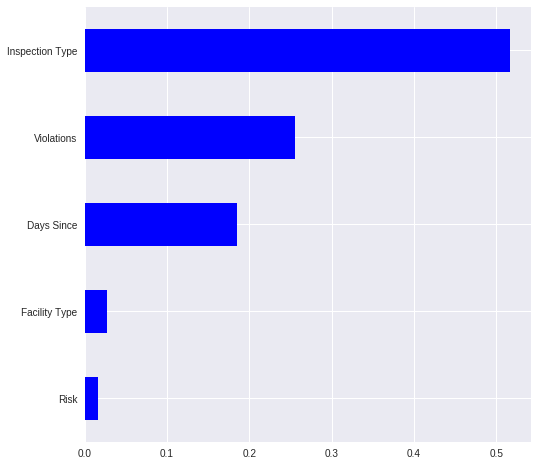

In [18]:
def show_feature_importances(
    pipe, X, y, estimator_name='randomforestclassifier',
    n=20, figsize=(8, 8)):
    
    #pipe must not change dimensions of X dataframe
    pipe.fit(X, y)
    importances = pd.Series(
        pipe.named_steps[estimator_name].feature_importances_,
        X.columns)
    
    top_n = importances.sort_values(ascending=False)[:n]
    
    plt.figure(figsize=figsize)
    plt.title='Feature Importance'
    top_n.sort_values().plot.barh(color='blue')
    plt.title='Feature Importance'
    
show_feature_importances(pipe2, X_train, y_train)

### Gradient Boosting

In [19]:
X_train.head()

,Facility Type,Risk,Inspection Type,Violations,Days Since
0,Restaurant,Risk 1 (High),Canvass,True,553
1,Grocery Store,Risk 3 (Low),Complaint Re-Inspection,True,2710
2,Restaurant,Risk 1 (High),Canvass Re-Inspection,True,1081
3,Restaurant,Risk 2 (Medium),Canvass,True,1057
4,School,Risk 1 (High),Canvass,True,2993


#### Encode Ordinals

In [20]:
encoder = ce.OrdinalEncoder(handle_unknown='ignore', cols=['Facility Type', 'Risk', 'Inspection Type'])
X_trans = encoder.fit_transform(X_train)
X_trans.head(10)

,Facility Type,Risk,Inspection Type,Violations,Days Since
0,1,1,1,True,553
1,2,2,2,True,2710
2,1,1,3,True,1081
3,1,3,1,True,1057
4,3,1,1,True,2993
5,4,1,1,True,1124
6,1,3,1,True,799
7,1,1,4,True,2145
8,1,1,1,True,1575
9,1,1,5,True,2851


In [21]:
from xgboost import XGBClassifier

model = XGBClassifier()
cross_val_score(model, X_trans, y_train, scoring='accuracy', cv=5, n_jobs=-1)

array([0.76426775, 0.76330044, 0.76985586, 0.76625387, 0.76489938])

In [22]:
model.fit(X_trans, y_train)
pd.Series(model.feature_importances_, X_trans.columns)

Facility Type      0.123386
Risk               0.043042
Inspection Type    0.433286
Violations         0.107604
Days Since         0.292683
dtype: float32

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._


####  Partial Dependency Plots

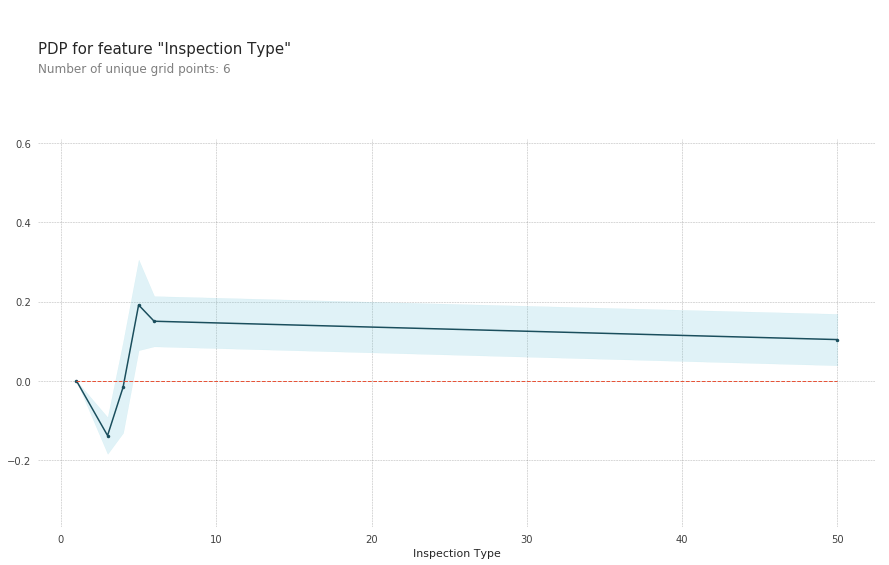

In [23]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='Inspection Type'
pdp_isolated = pdp_isolate(model=model, dataset=X_trans, model_features=X_trans.columns, 
                           feature=feature)

pdp_plot(pdp_isolated, feature);

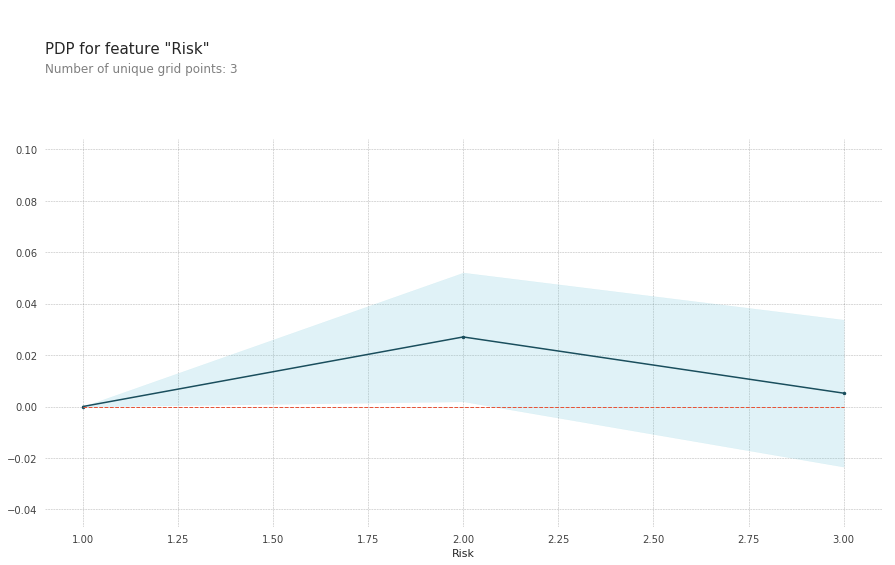

In [24]:
feature='Risk'
pdp_isolated = pdp_isolate(model=model, dataset=X_trans, model_features=X_trans.columns, 
                           feature=feature)

pdp_plot(pdp_isolated, feature);

#### Permutation Importance

In [26]:
import eli5
from eli5.sklearn import PermutationImportance
encoder = ce.OrdinalEncoder()
X_train_transformed = encoder.fit_transform(X_train)

model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    min_samples_leaf=0.005, 
    n_jobs=-1)

model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(model, scoring='roc_auc',
                                n_iter=1, cv='prefit')
permuter.fit(X_train_transformed, y_train)

PermutationImportance(cv='prefit',
           estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.005,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
           n_iter=1, random_state=None, refit=True, scoring='roc_auc')

In [27]:
eli5.show_weights(permuter, top=None, feature_names=X_train_transformed.columns.tolist())

Weight,Feature
0.1421 ± 0.0000,Inspection Type
0.0763 ± 0.0000,Violations
0.0513 ± 0.0000,Days Since
0.0103 ± 0.0000,Facility Type
0.0090 ± 0.0000,Risk
